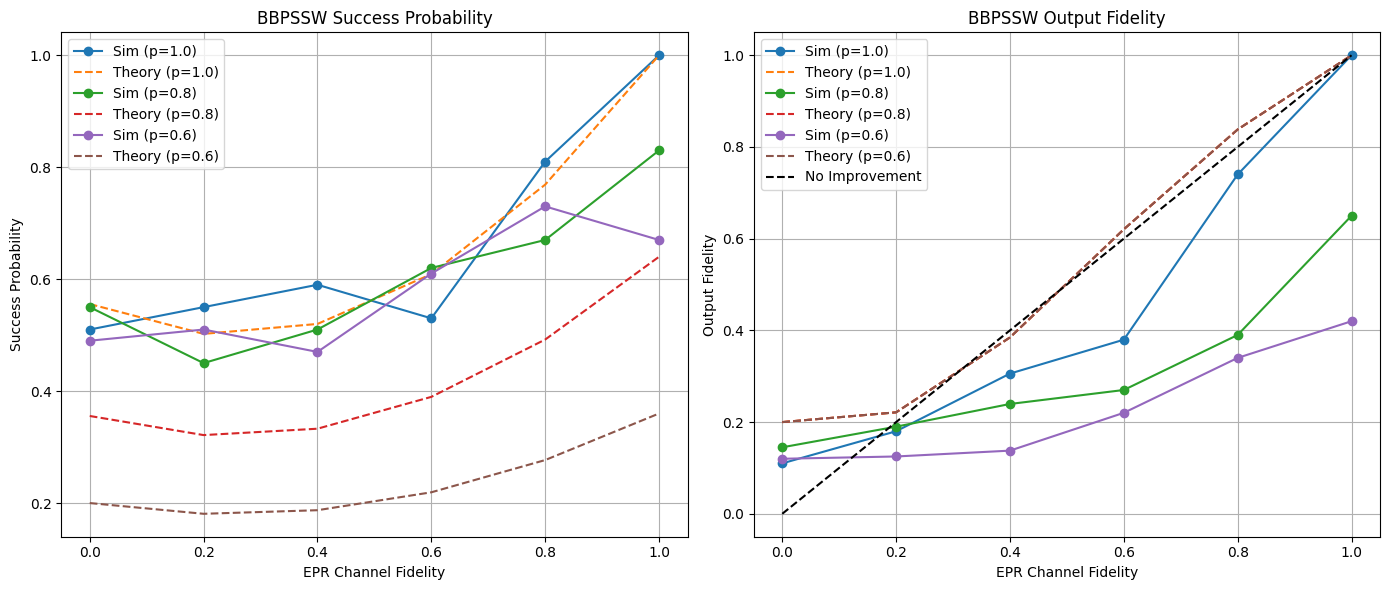

/tmp/ipykernel_494198/3534927300.py:25: RuntimeWarning: invalid value encountered in sqrt
  sqrt_term = np.sqrt(4 + 6/p - 9/(p**2))


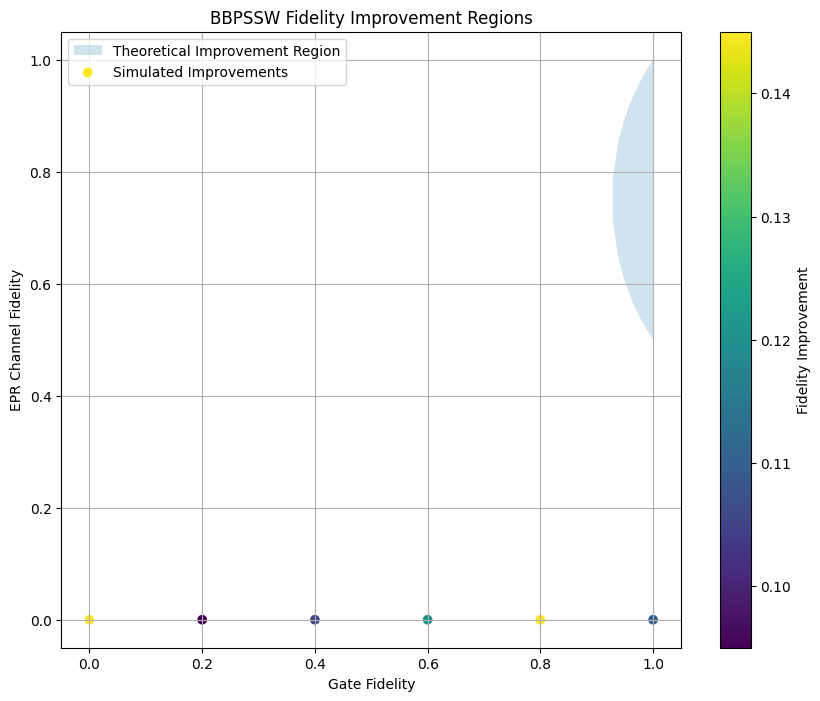

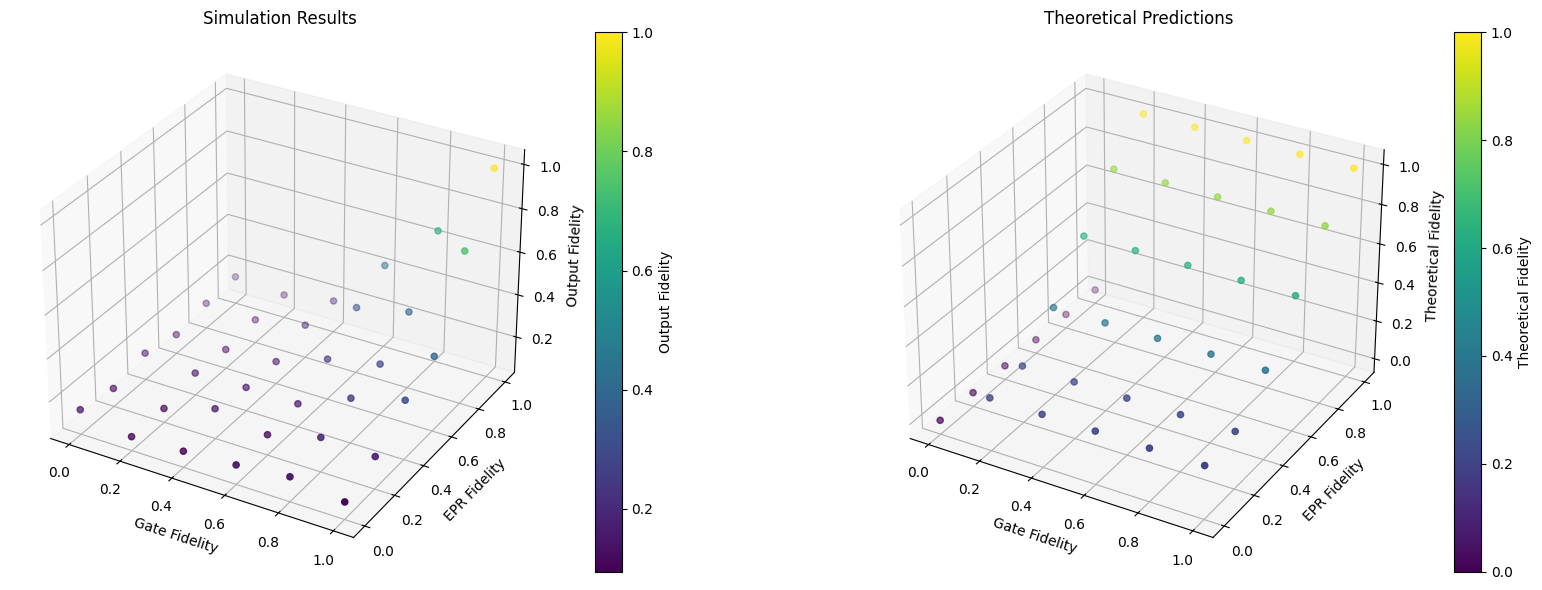

BBPSSW Protocol Statistics:
Max simulated fidelity: 1.000
Max theoretical fidelity: 1.000


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def prob_succ_theory(F: float, gate_fidelity: float = 1.0):
    """Theoretical success probability for BBPSSW protocol with gate noise."""
    p = gate_fidelity
    term1 = F**2
    term2 = 2 * F * (1 - F) / 3
    term3 = 5 * ((1 - F)**2) / 9
    return (term1 + term2 + term3) * (p**2)

def fidelity_succ_theory(F: float, gate_fidelity: float = 1.0):
    """Theoretical fidelity after successful BBPSSW iteration with gate noise."""
    p = gate_fidelity
    numerator = (F**2 + ((1 - F)**2)/9) * (p**2)
    denominator = prob_succ_theory(F, gate_fidelity)
    return numerator / denominator if denominator != 0 else 0

def f_threshold(gate_fidelity: float):
    """Compute F_min and F_max where F_succ > F for a given gate fidelity."""
    p = gate_fidelity
    sqrt_term = np.sqrt(4 + 6/p - 9/(p**2))
    F_max = 0.75 + 0.25 * sqrt_term
    F_min = 0.75 - 0.25 * sqrt_term
    return F_min, F_max

def analyze_bbpssw(filepath='./out_bbpssw.csv'):
    """Main analysis function for BBPSSW protocol"""
    # Load and preprocess data
    df = pd.read_csv(filepath)
    df['Success'] = (df['M_Alice'] == df['M_Bob'])
    grouped = df.groupby(['Gate fidelity', 'EPR channel fidelity']).agg({
        'Success': 'mean',
        'Fidelity': 'mean'
    }).reset_index()
    grouped.rename(columns={
        'Success': 'Success Probability',
        'Fidelity': 'Average Fidelity'
    }, inplace=True)

    # Add theoretical predictions
    grouped['Theory Success'] = grouped.apply(
        lambda row: prob_succ_theory(row['EPR channel fidelity'], row['Gate fidelity']),
        axis=1
    )
    grouped['Theory Fidelity'] = grouped.apply(
        lambda row: fidelity_succ_theory(row['EPR channel fidelity'], row['Gate fidelity']),
        axis=1
    )

    # Generate plots
    plot_comparison(grouped)
    plot_fidelity_threshold(grouped)
    plot_3d_comparison(grouped)

    return grouped

def plot_comparison(grouped):
    """Compare simulation results with theoretical predictions"""
    plt.figure(figsize=(14, 6))

    # Success probability comparison
    plt.subplot(1, 2, 1)
    for p in [1.0, 0.8, 0.6]:
        subset = grouped[grouped['Gate fidelity'] == p]
        plt.plot(subset['EPR channel fidelity'], subset['Success Probability'],
                'o-', label=f'Sim (p={p})')
        theory = subset['EPR channel fidelity'].apply(
            lambda F: prob_succ_theory(F, p))
        plt.plot(subset['EPR channel fidelity'], theory, '--', label=f'Theory (p={p})')

    plt.xlabel('EPR Channel Fidelity')
    plt.ylabel('Success Probability')
    plt.title('BBPSSW Success Probability')
    plt.legend()
    plt.grid(True)

    # Fidelity comparison
    plt.subplot(1, 2, 2)
    for p in [1.0, 0.8, 0.6]:
        subset = grouped[grouped['Gate fidelity'] == p]
        plt.plot(subset['EPR channel fidelity'], subset['Average Fidelity'],
                'o-', label=f'Sim (p={p})')
        theory = subset['EPR channel fidelity'].apply(
            lambda F: fidelity_succ_theory(F, p))
        plt.plot(subset['EPR channel fidelity'], theory, '--', label=f'Theory (p={p})')

    plt.plot([0,1], [0,1], 'k--', label='No Improvement')
    plt.xlabel('EPR Channel Fidelity')
    plt.ylabel('Output Fidelity')
    plt.title('BBPSSW Output Fidelity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_fidelity_threshold(grouped):
    """Plot fidelity improvement regions with theoretical thresholds"""
    plt.figure(figsize=(10, 8))

    # Theoretical thresholds
    p_vals = np.linspace(0.5, 1, 50)
    F_mins, F_maxs = zip(*[f_threshold(p) for p in p_vals])

    plt.fill_between(p_vals, F_mins, F_maxs, alpha=0.2, label='Theoretical Improvement Region')

    # Simulation results
    improved = grouped[grouped['Average Fidelity'] > grouped['EPR channel fidelity']]
    plt.scatter(improved['Gate fidelity'], improved['EPR channel fidelity'],
               c=improved['Average Fidelity'] - improved['EPR channel fidelity'],
               cmap='viridis', label='Simulated Improvements')

    plt.colorbar(label='Fidelity Improvement')
    plt.xlabel('Gate Fidelity')
    plt.ylabel('EPR Channel Fidelity')
    plt.title('BBPSSW Fidelity Improvement Regions')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_3d_comparison(grouped):
    """3D visualization of simulation vs theory"""
    fig = plt.figure(figsize=(18, 6))

    # Simulation results
    ax1 = fig.add_subplot(121, projection='3d')
    sc1 = ax1.scatter(grouped['Gate fidelity'], grouped['EPR channel fidelity'],
                     grouped['Average Fidelity'], c=grouped['Average Fidelity'],
                     cmap='viridis')
    ax1.set_xlabel('Gate Fidelity')
    ax1.set_ylabel('EPR Fidelity')
    ax1.set_zlabel('Output Fidelity')
    ax1.set_title('Simulation Results')
    fig.colorbar(sc1, ax=ax1, label='Output Fidelity')

    # Theoretical predictions
    ax2 = fig.add_subplot(122, projection='3d')
    sc2 = ax2.scatter(grouped['Gate fidelity'], grouped['EPR channel fidelity'],
                     grouped['Theory Fidelity'], c=grouped['Theory Fidelity'],
                     cmap='viridis')
    ax2.set_xlabel('Gate Fidelity')
    ax2.set_ylabel('EPR Fidelity')
    ax2.set_zlabel('Theoretical Fidelity')
    ax2.set_title('Theoretical Predictions')
    fig.colorbar(sc2, ax=ax2, label='Theoretical Fidelity')

    plt.tight_layout()
    plt.show()

def print_statistics(grouped):
    print("BBPSSW Protocol Statistics:")
    print(f"Max simulated fidelity: {grouped['Average Fidelity'].max():.3f}")
    print(f"Max theoretical fidelity: {grouped['Theory Fidelity'].max():.3f}")


# Run full analysis
bbpssw_data = analyze_bbpssw()
print_statistics(bbpssw_data)

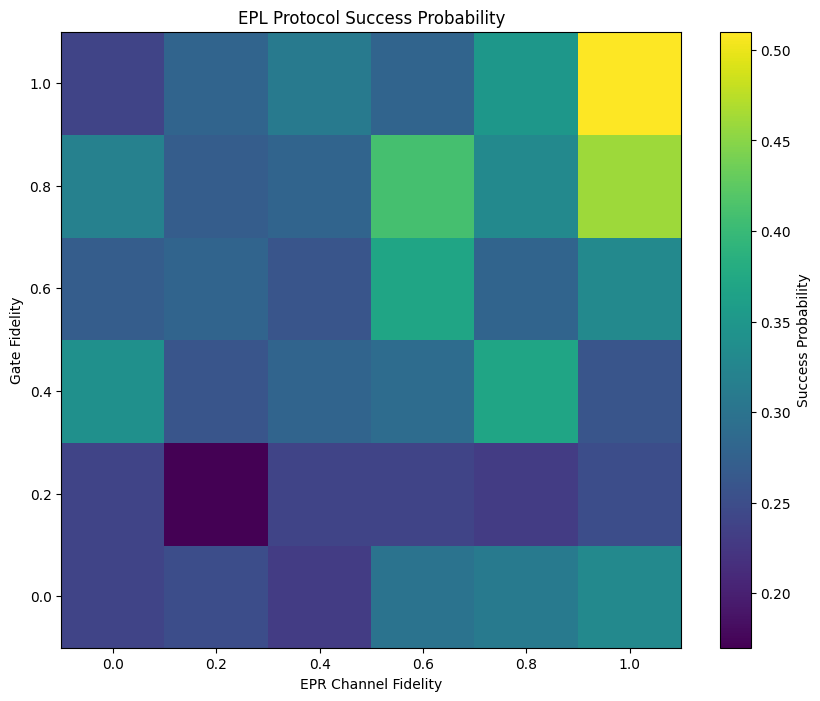

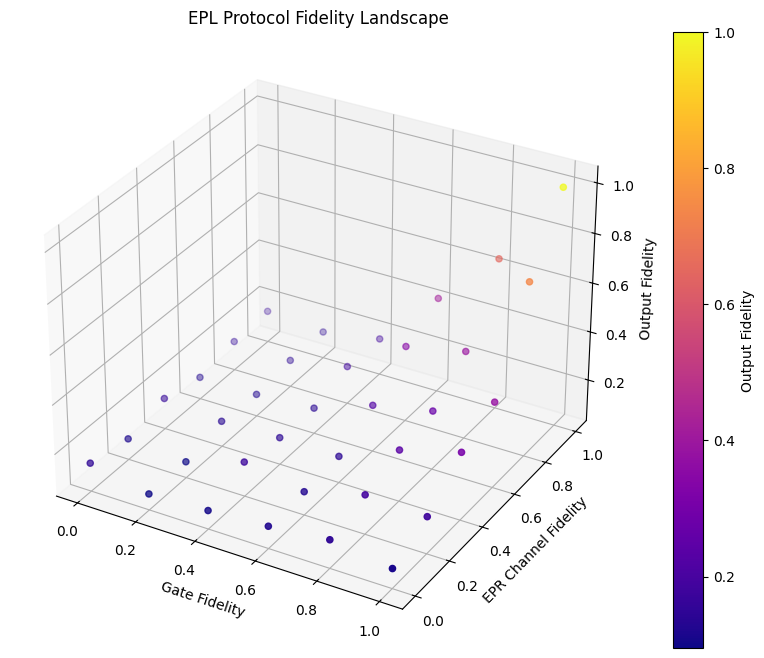

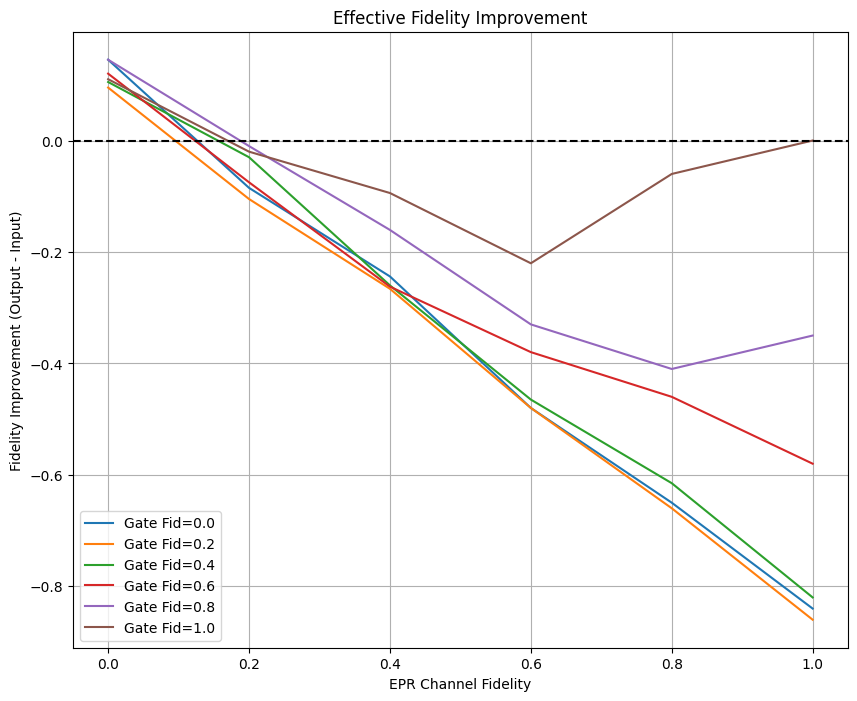

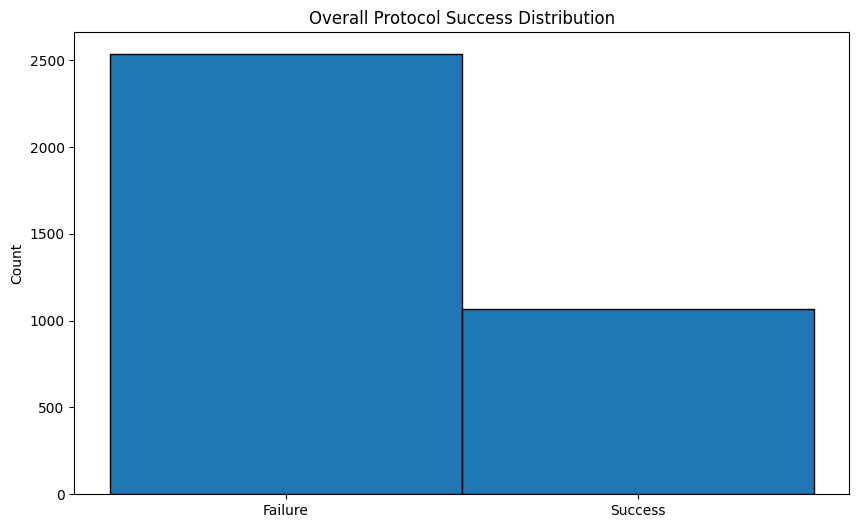

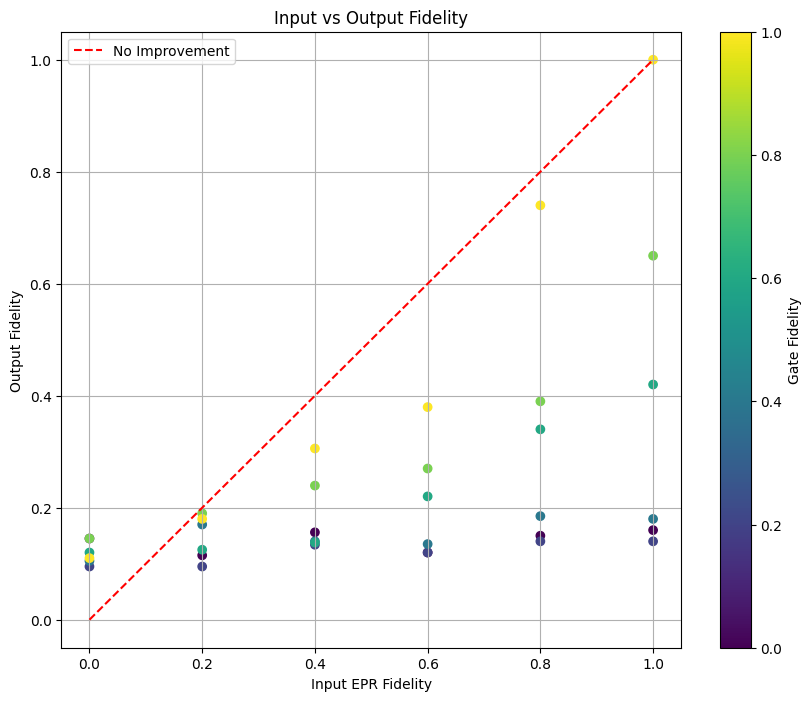

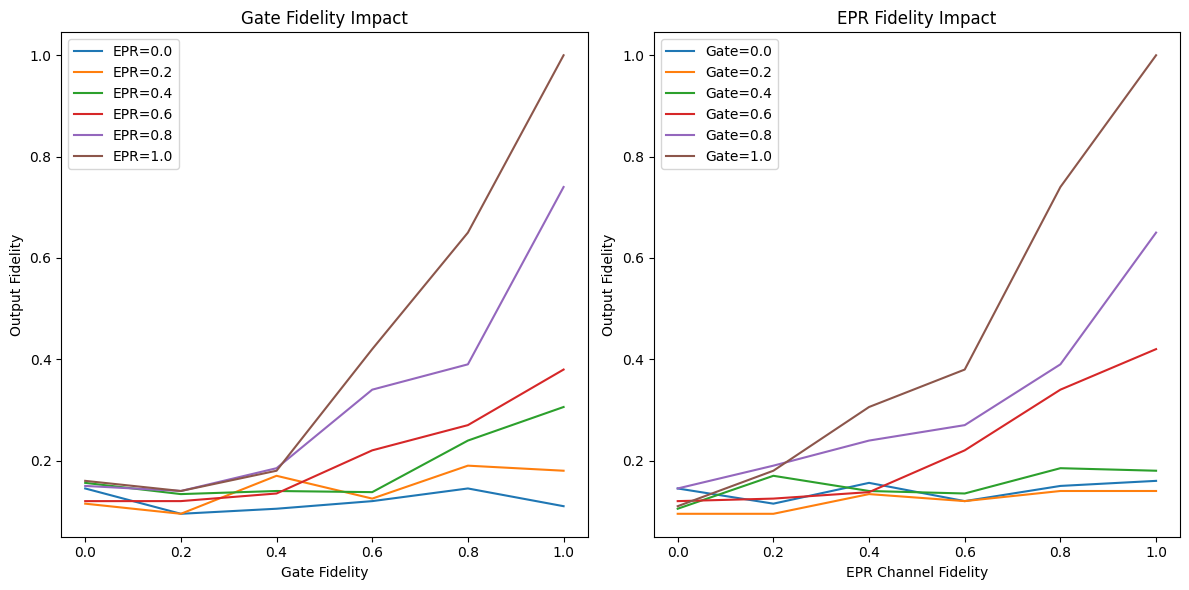


Key Statistics:
Maximum success probability: 0.51
Maximum output fidelity: 1.00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_and_preprocess(filepath='./out_bbpssw.csv'):
    df = pd.read_csv(filepath)

    # Calculate success flag
    df['Success'] = (df['M_Alice'] == 1) & (df['M_Bob'] == 1)

    # Calculate success probability and average fidelity per configuration
    grouped = df.groupby(['Gate fidelity', 'EPR channel fidelity']).agg({
        'Success': 'mean',
        'Fidelity': 'mean'
    }).reset_index()

    grouped.rename(columns={
        'Success': 'Success Probability',
        'Fidelity': 'Average Fidelity'
    }, inplace=True)

    return df, grouped

def plot_success_heatmap(grouped):
    """Heatmap of success probability vs input parameters."""
    pivoted = grouped.pivot(index='Gate fidelity',
                          columns='EPR channel fidelity',
                          values='Success Probability')

    plt.figure(figsize=(10, 8))
    plt.imshow(pivoted, origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label='Success Probability')
    plt.xticks(np.arange(len(pivoted.columns)), pivoted.columns.values.round(2))
    plt.yticks(np.arange(len(pivoted.index)), pivoted.index.values.round(2))
    plt.xlabel('EPR Channel Fidelity')
    plt.ylabel('Gate Fidelity')
    plt.title('EPL Protocol Success Probability')
    plt.show()

def plot_fidelity_improvement(grouped):
    """3D plot of fidelity improvements"""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = grouped['Gate fidelity']
    y = grouped['EPR channel fidelity']
    z = grouped['Average Fidelity']

    sc = ax.scatter(x, y, z, c=z, cmap='plasma')
    ax.set_xlabel('Gate Fidelity')
    ax.set_ylabel('EPR Channel Fidelity')
    ax.set_zlabel('Output Fidelity')
    fig.colorbar(sc, label='Output Fidelity')
    plt.title('EPL Protocol Fidelity Landscape')
    plt.show()

def plot_effective_improvement(grouped):
    """Plot regions where fidelity improves beyond input"""
    plt.figure(figsize=(10, 8))

    for gate_fid in np.unique(grouped['Gate fidelity']):
        subset = grouped[grouped['Gate fidelity'] == gate_fid]
        plt.plot(subset['EPR channel fidelity'],
                 subset['Average Fidelity'] - subset['EPR channel fidelity'],
                 label=f'Gate Fid={gate_fid:.1f}')

    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('EPR Channel Fidelity')
    plt.ylabel('Fidelity Improvement (Output - Input)')
    plt.title('Effective Fidelity Improvement')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_success_distribution(raw_df):
    plt.figure(figsize=(10, 6))
    plt.hist(raw_df['Success'].astype(int), bins=[-0.5, 0.5, 1.5],
             edgecolor='black', align='mid')
    plt.xticks([0, 1], ['Failure', 'Success'])
    plt.ylabel('Count')
    plt.title('Overall Protocol Success Distribution')
    plt.show()

def plot_fidelity_comparison(grouped_df):
    plt.figure(figsize=(10, 8))
    plt.scatter(grouped_df['EPR channel fidelity'],
                grouped_df['Average Fidelity'],
                c=grouped_df['Gate fidelity'],
                cmap='viridis')
    plt.colorbar(label='Gate Fidelity')
    plt.plot([0,1], [0,1], 'r--', label='No Improvement')
    plt.xlabel('Input EPR Fidelity')
    plt.ylabel('Output Fidelity')
    plt.title('Input vs Output Fidelity')
    plt.legend()
    plt.grid(True)
    plt.show()

def parameter_sensitivity(grouped_df):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for epr_fid in np.unique(grouped_df['EPR channel fidelity']):
        subset = grouped_df[grouped_df['EPR channel fidelity'] == epr_fid]
        plt.plot(subset['Gate fidelity'], subset['Average Fidelity'],
                 label=f'EPR={epr_fid:.1f}')
    plt.xlabel('Gate Fidelity')
    plt.ylabel('Output Fidelity')
    plt.title('Gate Fidelity Impact')
    plt.legend()

    plt.subplot(1, 2, 2)
    for gate_fid in np.unique(grouped_df['Gate fidelity']):
        subset = grouped_df[grouped_df['Gate fidelity'] == gate_fid]
        plt.plot(subset['EPR channel fidelity'], subset['Average Fidelity'],
                 label=f'Gate={gate_fid:.1f}')
    plt.xlabel('EPR Channel Fidelity')
    plt.ylabel('Output Fidelity')
    plt.title('EPR Fidelity Impact')
    plt.legend()

    plt.tight_layout()
    plt.show()

def analyze_protocol_performance():
    # Load and preprocess data
    raw_df, grouped_df = load_and_preprocess()

    # Generate plots
    plot_success_heatmap(grouped_df)
    plot_fidelity_improvement(grouped_df)
    plot_effective_improvement(grouped_df)

    # New analyses
    plot_success_distribution(raw_df)
    plot_fidelity_comparison(grouped_df)
    parameter_sensitivity(grouped_df)

    # Print key statistics
    print("\nKey Statistics:")
    print(f"Maximum success probability: {grouped_df['Success Probability'].max():.2f}")
    print(f"Maximum output fidelity: {grouped_df['Average Fidelity'].max():.2f}")


# Run the analysis
analyze_protocol_performance()